In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim

In [2]:
LOAD_CHECKPOINT = False
checkpoint_name = ''
checkpoint = {}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyperparameters

In [4]:
lr = 1e-3
batch_size = 16
np.random.seed(14)

## Data Setup

In [5]:
def split(inputDirName, outputDirName, s=[.7, .3], reset=True):
    if reset:
        shutil.rmtree(outputDirName)
    try:
        os.mkdir(outputDirName)
        os.mkdir(os.path.join(outputDirName, 'train'))
        os.mkdir(os.path.join(outputDirName, 'val'))
    except FileExistsError:
        pass
    
    categories = os.listdir(inputDirName)
    for c in categories:
        imgs = os.listdir(os.path.join(inputDirName, c))
        numTrain = int(s[0] * len(imgs))
        train = np.random.choice(imgs, size=numTrain, replace=False)
        val = list(set(imgs) - set(train))
        try:
            os.mkdir(os.path.join(outputDirName, 'train', c))
            os.mkdir(os.path.join(outputDirName, 'val', c))
        except FileExistsError:
            pass
        for img in train:
            shutil.copyfile(os.path.join(inputDirName, c, img),
                            os.path.join(outputDirName, 'train', c, img))
        for img in val:
            shutil.copyfile(os.path.join(inputDirName, c, img),
                os.path.join(outputDirName, 'val', c, img))

In [6]:
data_dir = 'mmod_images'

split('all_images', 'mmod_images')

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(.6, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomGrayscale(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [8]:
datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=1)
               for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
class_names = datasets['train'].classes

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

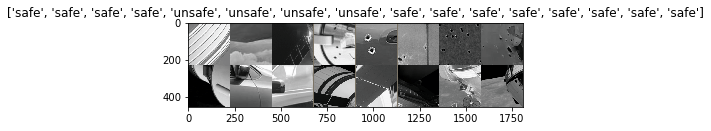

In [10]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Helpers

In [11]:
def train(model, lossFunc, optimizer, history, checkpoint_every, save_checkpoints,
          num_epochs, start_epoch):
    for epoch in range(start_epoch, start_epoch+num_epochs):
        print(f'Epoch {epoch+1}')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0
            num_correct = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunc(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                epoch_loss += loss.item() * inputs.size(0)
                num_correct += torch.sum(preds == labels.data)
            
            epoch_loss = epoch_loss / dataset_sizes[phase]
            epoch_acc = num_correct.double() / dataset_sizes[phase]
            
            if phase == 'train':
                history.add_train_loss(epoch_loss)
                history.add_train_acc(epoch_acc)
            else:
                history.add_val_loss(epoch_loss)
                history.add_val_acc(epoch_acc)
                
        if save_checkpoints and (epoch + 1) % checkpoint_every == 0:
            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')
            save(model=model, optimzer=optimizer, epoch_num=epoch+1,
                 lossFunc=lossFunc, history=history, arch=MODEL_ARCH)
    return model, optimizer, history

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
class History():
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        
    def add_train_loss(self, l):
        self.train_loss.append(l)
    
    def add_val_loss(self, l):
        self.val_loss.append(l)
        
    def add_train_acc(self, a):
        self.train_acc.append(a)
    
    def add_val_acc(self, a):
        self.val_acc.append(a)

## Save/Load

In [14]:
def save(model, optimzer, epoch_num, lossFunc, history, arch):
    checkpoint = { \
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lossFunc': str(loss)[:-2],
        'train_loss': history.train_loss,
        'val_loss': history.val_loss,
        'arch': arch,
        'epoch_num': epoch_num
    }
    PATH = str(optimizer).split(' ')[0] 
    PATH += '_' + checkpoint['lossFunc']
    PATH += '_' + str(epoch_num)
    PATH += '_' + arch
    PATH += '_' + '%.3f'%(history.train_loss[-1])
    PATH += '_' + '%.3f'%(history.val_loss[-1])
    try:
        os.mkdir('checkpoints')
    except FileExistsError:
        pass
    PATH = os.path.join('checkpoints', PATH + '.ptc')
    torch.save(checkpoint, PATH)

In [15]:
if LOAD_CHECKPOINT:
    PATH = os.join('checkpoints', checkpoint_name + '.ptc')
    checkpoint = torch.load(PATH)
else:
    checkpoint['epoch_num'] = 0

## Train

In [16]:
# training setup
checkpoint_every = 10
save_checkpoints = True
num_epochs = 40
start_ep = checkpoint['epoch_num']

In [17]:
# downloads fully trained resnet18 model on first call
model = models.resnet34(pretrained=True)
MODEL_ARCH = 'resnet34'
# reset final layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
history = History()

if LOAD_CHECKPOINT:
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    history.train_loss = checkpoint['train_loss']
    history.val_loss = checkpoint['val_loss']

In [18]:
model, optimizer, history = train(model, loss, optimizer, history, 
                                       checkpoint_every,save_checkpoints,
                                       num_epochs=num_epochs, start_epoch=start_ep)
checkpoint['epoch_num'] += num_epochs

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
val Loss: 0.4738301958098556 Acc: 0.7696969696969697
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
val Loss: 0.4008985436098142 Acc: 0.8545454545454545
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
val Loss: 0.5484275051138617 Acc: 0.8242424242424242
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
val Loss: 0.44897539326638886 Acc: 0.8121212121212121


## Test 

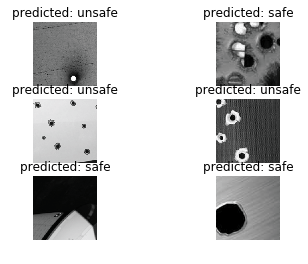

In [19]:
visualize_model(model)

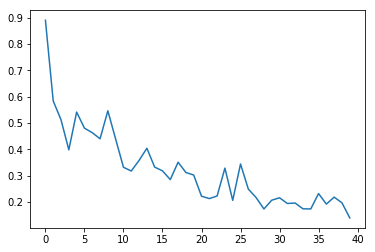

In [20]:
plt.plot(history.train_loss)

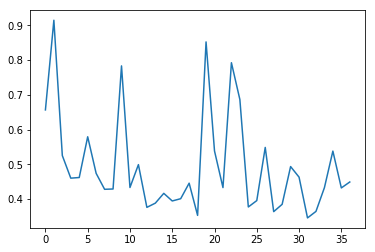

In [21]:
plt.plot(history.val_loss[3:])

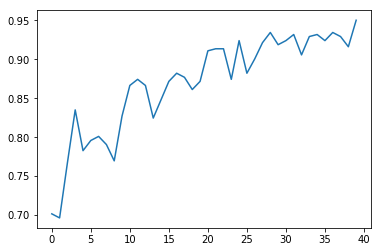

In [22]:
plt.plot(history.train_acc)

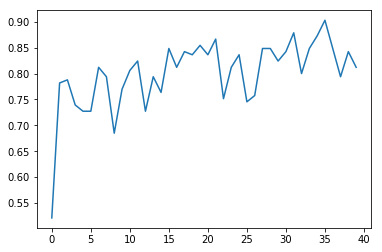

In [23]:
plt.plot(history.val_acc)

## Post Save

In [419]:
save(model=model, optimzer=optimizer, epoch_num=20,
     lossFunc=loss, history=history, arch=MODEL_ARCH)